In [1]:
#@title Imports & Utils
!pip install -q git+https://github.com/abhijeetgangan/jax-md.git

import jax.numpy as jnp
import numpy as onp
from functools import partial
from jax import debug
from jax import jit
from jax import grad
from jax import random
from jax import lax
from jax.config import config

config.update('jax_enable_x64', True)
from jax_md import simulate
from jax_md import space
from jax_md import energy
from jax_md import elasticity
from jax_md import quantity
from jax_md import dataclasses
from jax_md.util import f64

# Other libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 

def lattice(R_unit_cell, copies, lattice_vectors):
  """Repeats a unit cell along lattice vectors. """
  lattice_vectors = onp.array(lattice_vectors, f64)

  N, d = R_unit_cell.shape
  if isinstance(copies, int): 
    copies = (copies,) * d 

  if lattice_vectors.ndim == 0 or lattice_vectors.ndim == 1:
    cartesian = True
    L = onp.eye(d) * lattice_vectors[onp.newaxis, ...] 
  elif lattice_vectors.ndim == 2:
    assert lattice_vectors.shape[0] == lattice_vectors.shape[1] 
    cartesian = False
    L = onp.eye(d) / onp.array(copies)[onp.newaxis, ...]
    R_unit_cell /= onp.array(copies)[onp.newaxis, ...]
  else:
    raise ValueError()

  Rs = []
  for indices in onp.ndindex(copies):
    dR = 0.
    for idx, i in enumerate(indices):
      dR += i * L[idx]
    R = R_unit_cell + dR[onp.newaxis, :]
    Rs += [R]
  
  return onp.concatenate(Rs)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Using units in JAX-MD (NPT simulation - RDF)

This notebook demonstrates the use of a unit system (metal units) for the simulation of the Silicon crystal containing 512 atoms in the NPT ensemble with the Stillinger-Weber potential. The Si crystal is heated from 2500K. The crystal melts and the change is observed in the RDF.

More about the unit system https://docs.lammps.org/units.html

## Silicon unit cell

In [2]:
# Silicon Conventional cell
si_text_con = """0.250000 0.750000 0.250000 Si
0.000000 0.000000 0.500000 Si
0.250000 0.250000 0.750000 Si
0.000000 0.500000 0.000000 Si
0.750000 0.750000 0.750000 Si
0.500000 0.000000 0.000000 Si
0.750000 0.250000 0.250000 Si
0.500000 0.500000 0.500000 Si"""
latvec = jnp.array([[5.431, 0.000000, 0.000000], [0.00000, 5.431, 0.00000],[0.00000, 0.0000, 5.431]])
rows_con = si_text_con.split('\n')
rows_con = jnp.array([list(map(float,r.split(' ')[:3])) for r in rows_con])
positions = lattice(rows_con, 4, latvec) 
latvec *= 4.0 
jnp.result_type(rows_con)
print("Number of atoms = {}".format(positions.shape[0]))

Number of atoms = 512


## Units and simulation parameters


In [3]:
# Import unit system
from jax_md import units

# Metal units
unit = units.metal_unit_system()

In [4]:
# Simulation parameters
timestep = 1e-3
fs = timestep * unit['time']
ps = unit['time']
dt = fs
write_every = 100
box = latvec
T_init = 2500 * unit['temperature']
P_init = 0.0 * unit['pressure']
Mass = 28.0855 * unit['mass']
key = random.PRNGKey(121)
steps = 20000

## Simulation setup

In [5]:
# Setup the periodic boundary conditions. 
displacement, shift = space.periodic_general(latvec) 
dist_fun = space.metric(displacement) 
neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, latvec, disable_cell_list=True)
energy_fn = jit(energy_fn)

In [6]:
dr = 6/300
r = jnp.arange(0.0, 6.0, dr, dtype=f64)
gr_fn = jit(quantity.pair_correlation(displacement, radii=r, sigma=dr, compute_average=True))

In [7]:
# Logger to save data
log = {
'E': jnp.zeros((steps // write_every,)),
'P': jnp.zeros((steps // write_every,)),
'V': jnp.zeros((steps // write_every,)),
'kT': jnp.zeros((steps // write_every,)),
'gr': jnp.zeros((steps // write_every,) + r.shape),
'coords': jnp.zeros((steps // write_every,) + positions.shape)
}

In [8]:
from typing import Dict
# Thermostat and barostat parameters same as LAMMPS
def default_nhc_kwargs(tau: f64, overrides: Dict) -> Dict:
  default_kwargs = {'chain_length': 3, 'chain_steps': 1, 'sy_steps': 1, 'tau': tau}
  if overrides is None:
    return default_kwargs
  return {key: overrides.get(key, default_kwargs[key]) for key in default_kwargs}
  
new_kwargs = {'chain_length': 3, 'chain_steps': 1, 'sy_steps': 1,}

In [9]:
# Extra capacity to prevent overflow
nbrs = neighbor_fn.allocate(positions, box=box, extra_capacity=4)

# NPT simulation
init_fn, apply_fn = simulate.npt_nose_hoover(energy_fn, shift, dt=dt, pressure=P_init, kT=T_init, 
                                             barostat_kwargs=default_nhc_kwargs(1000 * dt, new_kwargs),
                                              thermostat_kwargs=default_nhc_kwargs(100 * dt, new_kwargs))
apply_fn = jit(apply_fn)
state = init_fn(key, positions, box=box, neighbor=nbrs, kT=T_init, mass=Mass)

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


## NPT simulation

In [10]:
@jit
def step_fn(i, state_nbrs_box_j):  
  state, nbrs, box, j = state_nbrs_box_j
  # Take a simulation step.
  t = i * dt
  state = apply_fn(state, neighbor=nbrs, kT=T_init, pressure=P_init)
  box = simulate.npt_box(state)
  nbrs = nbrs.update(state.position, neighbor=nbrs, box=box)
  return state, nbrs, box, j
    
@jit
def outer_sim_fn(j, state_nbrs_log_box):
  state, nbrs, log, box = state_nbrs_log_box

  # Quantities to calculate
  K  = quantity.kinetic_energy(momentum = state.momentum, mass=Mass)
  E  = energy_fn(state.position, box=box, neighbor=nbrs)
  kT = quantity.temperature(momentum = state.momentum, mass=Mass)
  P  = quantity.pressure(energy_fn, state.position, box, K, neighbor=nbrs)
  V = quantity.volume(3, box=box)
  gr = gr_fn(state.position) * V / state.position.shape[0]
  coords = space.transform(state.box, state.position)

  # Save the quantities
  log['V'] = log['V'].at[j].set(V)
  log['E'] = log['E'].at[j].set(E)
  log['kT'] = log['kT'].at[j].set(kT)
  log['P'] = log['P'].at[j].set(P)
  log['gr'] = log['gr'].at[j].set(gr)
  log['coords'] = log['coords'].at[j].set(coords)

  # Print the quantities
  debug.print('Step = {j} | Total Energy = {T}', j=j*write_every, T=E + K)

  @jit
  def inner_sim_fn(i, state_nbrs_box):
    return step_fn(i, state_nbrs_box)
      
  state, nbrs, box, j = lax.fori_loop(0, write_every, inner_sim_fn, (state, nbrs, box, j))

  return state, nbrs, log, box

In [11]:
state_r, nbrs_r, log_r, box_r = lax.fori_loop(0, int(steps/write_every), outer_sim_fn, (state, nbrs, log, box))

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Step = 0 | Total Energy = -2060.690808063455
Step = 100 | Total Energy = -2044.534435847936
Step = 200 | Total Energy = -2015.3104321147414
Step = 300 | Total Energy = -1979.8540591162678
Step = 400 | Total Energy = -1940.868228979673
Step = 500 | Total Energy = -1901.4917868081905
Step = 600 | Total Energy = -1869.8818291589746
Step = 700 | Total Energy = -1842.0368318811177
Step = 800 | Total Energy = -1836.6517875119252
Step = 900 | Total Energy = -1847.9003190234862
Step = 1000 | Total Energy = -1866.5391161888076
Step = 1100 | Total Energy = -1877.366973214022
Step = 1200 | Total Energy = -1874.5990381235274
Step = 1300 | Total Energy = -1858.2257957695163
Step = 1400 | Total Energy = -1842.1953569728303
Step = 1500 | Total Energy = -1840.4169467063887
Step = 1600 | Total Energy = -1851.2515278614212
Step = 1700 | Total Energy = -1860.9447657533365
Step = 1800 | Total Energy = -1871.2276871335866
Step = 1900 | Total Energy = -1869.9563819996754
Step = 2000 | Total Energy = -1863.9

In [12]:
# Check if neighbors overflowed
print(nbrs_r.did_buffer_overflow)

0


## Plotting

Note that you have to reconvert the units again.

In [13]:
Nsteps = int(steps/write_every)
t = jnp.arange(0, Nsteps,dtype=f64) * timestep * write_every

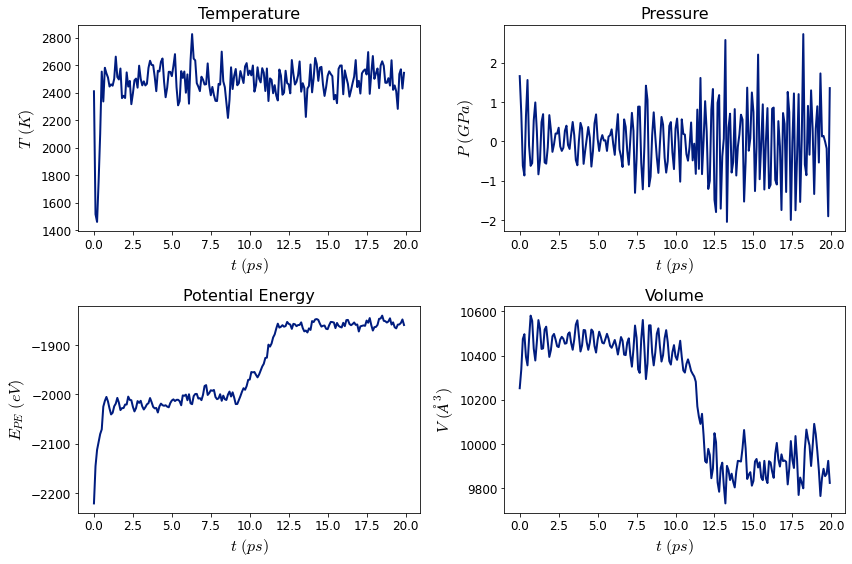

In [14]:
plt.style.use('seaborn-dark-palette')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot(2, 2, 1)
ax1.plot(t, log_r['kT'] / unit['temperature'], lw=2)
ax1.set_title('Temperature', fontsize=16)
ax1.set_ylabel("$T\ (K)$", fontsize=16)
ax1.set_xlabel("$t\ (ps)$", fontsize=16)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(t, (log_r['P'] / unit['pressure']) / 10000, lw=2)
ax2.set_title('Pressure', fontsize=16)
ax2.set_ylabel("$P\ (GPa)$", fontsize=16)
ax2.set_xlabel("$t\ (ps)$", fontsize=16)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(t, log_r['E'], lw=2)
ax3.set_title('Potential Energy', fontsize=16)
ax3.set_ylabel("$E_{PE}\ (eV)$", fontsize=16)
ax3.set_xlabel("$t\ (ps)$", fontsize=16)

ax4 = plt.subplot(2, 2, 4)
ax4.plot(t, log_r['V'], lw=2)
ax4.set_title('Volume', fontsize=16)
ax4.set_ylabel("$V\  (\AA^3)$", fontsize=16)
ax4.set_xlabel("$t\ (ps)$", fontsize=16)

fig.tight_layout()

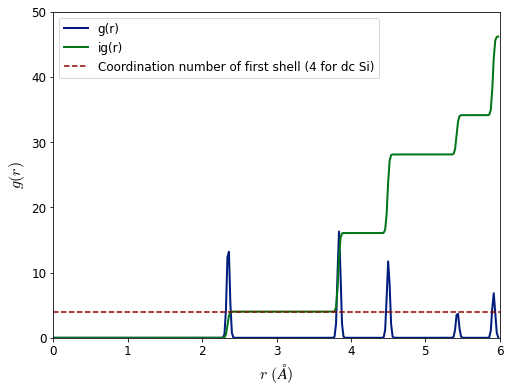

In [15]:
fig = plt.figure(figsize=(8, 6))
gr_calc = gr_fn(positions) * quantity.volume(3, latvec) / 512
igr_calc = jnp.cumsum(r*r*gr_calc*dr)
plt.xlabel(r"$r\ (\AA)$", fontsize=16)
plt.ylabel(r"$g(r)$", fontsize=16)
plt.plot(r, gr_calc ,  label='g(r)', lw=2)
plt.plot(r , igr_calc,  label='ig(r)', lw=2)
plt.plot([0.0,6.0],[4.0,4.0], label='Coordination number of first shell (4 for dc Si)', ls="--")
plt.xlim(0.0, 6.0)
plt.ylim(0.0, 50.0)
plt.legend()
plt.show()

In [16]:
from PIL import Image
from IPython.display import Image as IPYImage

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [17]:
files = []
for i in range(200):
  if i % 2 == 0:
    fig = plt.figure(figsize=(8, 6))
    gr_calc = log_r['gr'][i]
    igr_calc = jnp.cumsum(r*r*gr_calc*dr)
    plt.plot(r, gr_calc , lw=2, label='g(r)')
    plt.plot(r , igr_calc, lw=2, label='ig(r)')
    plt.xlim(0.0, 6.0)
    plt.ylim(0.0, 6.0)
    plt.title("MD step = {}".format(i*write_every))
    plt.xlabel(r"$r\ (\AA)$", fontsize=16)
    plt.ylabel(r"$g(r)$", fontsize=16)
    plt.legend()
    file = "/content/rdf_%.8i.png"%(i+1)
    plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    files.append(file)
    plt.close("all")
            
save_gif_PIL("rdf.gif", files, fps=10, loop=0)
!rm rdf_*

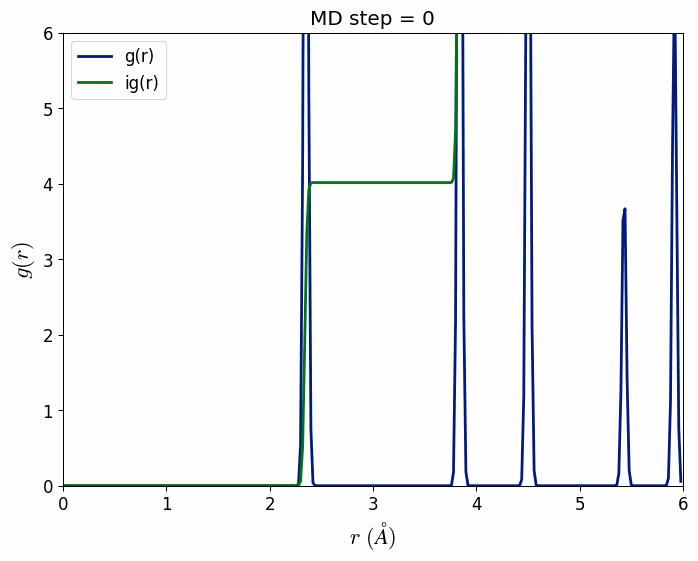

In [18]:
IPYImage(open('/content/rdf.gif','rb').read())

In [19]:
from jax_md.colab_tools import renderer

trajectory = jnp.stack(log_r['coords'])

renderer.render(latvec[0][0],
                {
                    'atoms': renderer.Sphere(trajectory),
                },
                resolution=(512,512), frame_rate=20)